In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from IPython.display import display, Markdown

import re
import nltk #Natural Language Toolkit
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
train_data_df         = pd.read_csv('/home/lenny/Python-Notebooks/Movie-Genre-Classification/train_data.txt', sep=" ::: ", engine='python'
  , header=None, names=["ID", "Title", "Genre", "Description"])
test_data_df          = pd.read_csv('/home/lenny/Python-Notebooks/Movie-Genre-Classification/test_data.txt', sep=" ::: ", engine='python'
  , header=None, names=["ID", "Title", "Description"])
test_data_solution_df = pd.read_csv('/home/lenny/Python-Notebooks/Movie-Genre-Classification/test_data_solution.txt', sep=" ::: ", engine='python'
  , header=None, names=["ID", "Genre", "Description"])

def Explore(title_, dataframe_):
    display(Markdown(title_))
    display(Markdown('---'))
    display(dataframe_.head())
    display('Descriptive Statistics')
    display(dataframe_.describe())
    display('Missing Values')
    display(dataframe_.isnull().sum().sort_values(ascending=False)) 
    display('Column Data Types')
    display(dataframe_.dtypes) 
  
Explore('### Train Data', train_data_df) 
Explore('### Test Data', test_data_df)   
Explore('### Test Data Solutions', test_data_solution_df)  

### Train Data

---

,ID,Title,Genre,Description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


'Descriptive Statistics'

,ID
count,54214.000000
mean,27107.500000
std,15650.378084
min,1.000000
25%,13554.250000
50%,27107.500000
75%,40660.750000
max,54214.000000


'Missing Values'

ID             0
Title          0
Genre          0
Description    0
dtype: int64

'Column Data Types'

ID              int64
Title          object
Genre          object
Description    object
dtype: object

### Test Data

---

,ID,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apart..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty chi..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family o...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with his..."
4,5,Er nu zhai (1955),Before he was known internationally as a marti...


'Descriptive Statistics'

,ID
count,54200.000000
mean,27100.500000
std,15646.336632
min,1.000000
25%,13550.750000
50%,27100.500000
75%,40650.250000
max,54200.000000


'Missing Values'

ID             0
Title          0
Description    0
dtype: int64

'Column Data Types'

ID              int64
Title          object
Description    object
dtype: object

### Test Data Solutions

---

,ID,Genre,Description
1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apart..."
2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty chi..."
3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...
4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with his..."
5,Er nu zhai (1955),drama,Before he was known internationally as a marti...


'Descriptive Statistics'

,ID,Genre,Description
count,54200,54200,54200
unique,54200,27,54072
top,Curitiba Zero Grau (2010),drama,Grammy - music award of the American academy o...
freq,1,13612,10


'Missing Values'

ID             0
Genre          0
Description    0
dtype: int64

'Column Data Types'

ID             object
Genre          object
Description    object
dtype: object

--- 
# Data Preprocessing

In [3]:
# Convert training data samples to lowercase.
# 'apply' applies the function to each column rather than individual cells.
train_data_df[['Title', 'Genre', 'Description']] = train_data_df[['Title', 'Genre', 'Description']].apply(lambda x: x.str.lower())

# Remove character that aren't letter a-zA-Z, white spaces in the case of genre and description and for title we also preserve numbers to account for release dates which could be valuable information.
# 'map' applies the function to individual cells.
train_data_df[['Genre', 'Description']] = train_data_df[['Genre', 'Description']].map(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
train_data_df[['Title']] = train_data_df[['Title']].map(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
train_data_df.head()

,ID,Title,Genre,Description
0,1,oscar et la dame rose 2009,drama,listening in to a conversation between his doc...
1,2,cupid 1997,thriller,a brother and sister with a past incestuous re...
2,3,young wild and wonderful 1980,adult,as the bus empties the students for their fiel...
3,4,the secret sin 1915,drama,to help their unemployed father make ends meet...
4,5,the unrecovered 2007,drama,the films title refers not only to the unrecov...


In [4]:
# Download stopwords onto ram
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

train_data_df['Description'] = train_data_df['Description'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
train_data_df.head()


[nltk_data] Downloading package stopwords to /home/lenny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,ID,Title,Genre,Description
0,1,oscar et la dame rose 2009,drama,listening conversation doctor parents yearold ...
1,2,cupid 1997,thriller,brother sister past incestuous relationship cu...
2,3,young wild and wonderful 1980,adult,bus empties students field trip museum natural...
3,4,the secret sin 1915,drama,help unemployed father make ends meet edith tw...
4,5,the unrecovered 2007,drama,films title refers unrecovered bodies ground z...


---
### Vectorizer

$$
TF(w) = \frac{\text{Number of times w appears in d}}{\text{Total number of words in d}}
$$
where :
- w is word
- d is document(sample)
$$
IDF(w) = \log({\frac{N}{\text{DF}(w)}+1})
$$
where :
- N = Total number of documents(samples)
- DF(w) = Number of documents that contain w
- Adding 1 in the denominator prevents division by zero

$$
TFIDF(w,d) = TF(w,d) * (\text{IDF}(w))
$$

- Implementation of the above formulas can differ based on how the TfidfVectorizer is intialized accounting for smoothing, normalization etc.

In [5]:
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(train_data_df['Description'])

In [6]:
# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Convert the matrix to a readable format
# tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
print(feature_names)

['aa' 'aaa' 'aaadyatmic' ... 'zyzyphus' 'zz' 'zzimo']


In [7]:
tfidf_matrix.shape

(54214, 146144)

---
# Machine Learning

In [8]:
# Intialize a list for inertia
# k_cluster_inertia = []

# # Loop through 50 clusters
# for i in range(1,51):
#     kmeans_range     = KMeans(n_clusters=i, random_state=42)
#     kmeans_range.fit(tfidf_matrix)
#     k_cluster_inertia.append(kmeans_range.inertia_)

In [9]:
# Store Interia values using joblib to compare later with lower dimension data
# dump(k_cluster_inertia, 'K-cluster-ineria-high-dimensionality')

In [10]:
# Trained in google colab
k_cluster_inertia = load('K-cluster-ineria-high-dimensionality-gc')

<function matplotlib.pyplot.show(close=None, block=None)>

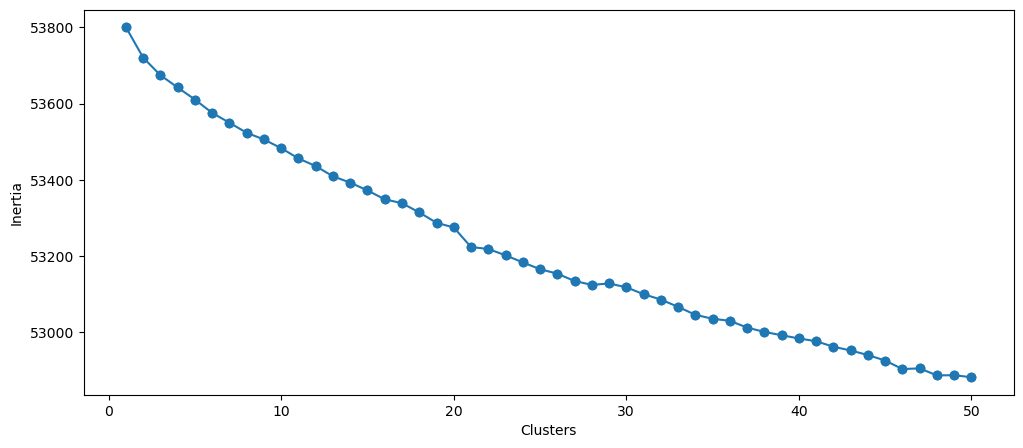

In [12]:
high_dimensional_kmeans = pd.DataFrame({'Clsuters' : range(1,51), 'Inertia' : k_cluster_inertia})

plt.figure(figsize=(12,5))
plt.scatter(x=high_dimensional_kmeans['Clsuters'], y=high_dimensional_kmeans['Inertia'])
plt.plot(high_dimensional_kmeans['Clsuters'], high_dimensional_kmeans['Inertia'], marker='o')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.show


---
# Principal Component Analysis